In [52]:
from argparse import Namespace

import numpy as np
import pandas as pd
import torch
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from e3nn import o3
from e3nn.io import CartesianTensor
from torch_geometric.data import Data
import plotly.express as px

from data import GLAMM_rhotens_Dataset as GLAMM_Dataset
from data import elasticity_func

In [2]:
dataset = GLAMM_Dataset(
    root='C:/temp/gnn-paper-data/GLAMMDset',
    catalogue_path='C:/temp/gnn-paper-data/train.lat',
    dset_fname='train.pt',
    n_reldens=10,
    graph_ft_format='cartesian_4'
)

Processing...


Processing catalogue train.lat. Number of lattices 7000 x 10 = 70000, Representation fund_inner. Nodal features: ones. Edge features: r. Graph feature format cartesian_4.


100%|██████████| 7000/7000 [00:24<00:00, 288.90it/s]
Done!


In [3]:
def stiffness_cart_4_to_Voigt(C: torch.Tensor) -> torch.Tensor:
    C_2 = torch.zeros((C.size(0),6,6), device=C.device)
    for i in range(6):
        if i<3:
            a = b = i
        elif i==3:
            a = 1; b = 2
        elif i==4:
            a = 0; b = 2
        else:
            a = 0; b = 1
        for j in range(i,6):
            if j<3:
                c = d = j
            elif j==3:
                c = 1; d = 2
            elif j==4:
                c = 0; d = 2
            else:
                c = 0; d = 1
            Cij = C[:,a,b,c,d] 
            C_2[:,i,j] = Cij 
            C_2[:,j,i] = Cij
    return C_2

In [4]:
names = list(set(dataset.data.name))
# name = np.random.choice(dataset.data.name)
dfs = []
for name in tqdm(names):
    inds = np.flatnonzero(np.in1d(dataset.data.name, [name]))
    stiffness = dataset.data.stiffness[inds]
    stiffness = stiffness_cart_4_to_Voigt(stiffness)
    norm_stiffness = stiffness/dataset.data.rel_dens[inds].view(-1,1,1)
    rows, cols = np.triu_indices(6)
    el_constants = norm_stiffness[:, rows, cols]
    el_constants = el_constants / el_constants.mean(dim=0)
    std, mean = torch.std_mean(el_constants, dim=0)
    df = pd.DataFrame({'std':std.numpy(), 'spread':(std/mean).numpy(), 'i':np.arange(21), 'name':name})
    dfs.append(df)
df = pd.concat(dfs, axis=0, ignore_index=True)
df

100%|██████████| 7000/7000 [01:40<00:00, 69.38it/s]


,std,spread,i,name
0,0.000385,0.000385,0,ort_Z05.5_E369_p_0.02_-1599426334144357192
1,3.077880,3.077880,1,ort_Z05.5_E369_p_0.02_-1599426334144357192
2,32.695526,32.695503,2,ort_Z05.5_E369_p_0.02_-1599426334144357192
3,2.429495,2.429495,3,ort_Z05.5_E369_p_0.02_-1599426334144357192
4,2.098046,2.098046,4,ort_Z05.5_E369_p_0.02_-1599426334144357192
...,...,...,...,...
146995,0.035163,0.035163,16,tet_Z08.0_E246_p_0.02_8649695761524661304
146996,0.009438,0.009438,17,tet_Z08.0_E246_p_0.02_8649695761524661304
146997,0.002252,0.002252,18,tet_Z08.0_E246_p_0.02_8649695761524661304
146998,0.001175,0.001175,19,tet_Z08.0_E246_p_0.02_8649695761524661304


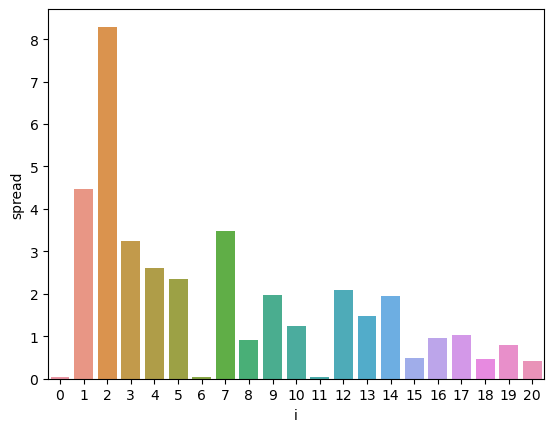

In [5]:
df_stat = df.groupby(by='i').mean()
df_stat.loc[:,'i'] = df_stat.index
sns.barplot(data=df_stat, x='i', y='spread')
plt.show()

# GNN output

In [11]:
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl

from gnn.models import LatticeGNN

In [8]:
params = Namespace(
    r_max=3, num_bessel=8, poly_cutoff=4, # Radial bessel embedding
    lmax=3, # spherical harmonics
    hidden_irreps='32x0e+32x1o+32x2e',
    readout_irreps='32x0e+32x1o+32x2e',
    interaction_reduction='mean',
    correlation=3,
    global_reduction='sum',
    message_passes=3,
    lr=0.001,
)
model = LatticeGNN(params).load_from_checkpoint('./gnn-paper-v0/1jtr2iy8/checkpoints/epoch=19-step=22400.ckpt')

In [10]:
trainer = pl.Trainer(
    accelerator='auto',
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
val_dset = GLAMM_Dataset(
    root='C:/temp/gnn-paper-data/GLAMMDset',
    catalogue_path='C:/temp/gnn-paper-data/train.lat',
    dset_fname='train.pt',
    n_reldens=10,
    graph_ft_format='cartesian_4'
)
el_tens = CartesianTensor('ijkl=jikl=ijlk=klij')
val_dset.data.stiffness = val_dset.data.stiffness / val_dset.data.rel_dens.view(-1,1,1,1,1)
normalization_factor = 3.3083
val_dset.data.stiffness = el_tens.from_cartesian(val_dset.data.stiffness*normalization_factor).float()

val_loader = DataLoader(
    dataset=val_dset,
    batch_size=100,
    shuffle=False,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

In [15]:
results = trainer.predict(model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\Anaconda3\envs\GLAMMenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [32]:
predictions = el_tens.to_cartesian(torch.cat([res[0]['stiffness'] for res in results], dim=0))
true = el_tens.to_cartesian(torch.cat([res[1]['stiffness'] for res in results], dim=0))
dset_names = np.concatenate([res[1]['name'] for res in results])

In [39]:
rows, cols = np.triu_indices(6)
names = np.unique(dset_names)
dfs = []
for name in tqdm(names):
    inds = np.flatnonzero(dset_names==name)
    norm_stiffness = predictions[inds]
    norm_stiffness = stiffness_cart_4_to_Voigt(norm_stiffness)
    el_constants = norm_stiffness[:, rows, cols]
    el_constants = el_constants / el_constants.mean(dim=0)
    std, mean = torch.std_mean(el_constants, dim=0)
    dfs.append(pd.DataFrame({'std':std.numpy(), 'spread':(std/mean).numpy(), 'i':np.arange(21), 'name':name, 'class':'pred'}))
    norm_stiffness = true[inds]
    norm_stiffness = stiffness_cart_4_to_Voigt(norm_stiffness)
    el_constants = norm_stiffness[:, rows, cols]
    el_constants = el_constants / el_constants.mean(dim=0)
    std, mean = torch.std_mean(el_constants, dim=0)
    dfs.append(pd.DataFrame({'std':std.numpy(), 'spread':(std/mean).numpy(), 'i':np.arange(21), 'name':name, 'class':'true'}))
df = pd.concat(dfs, axis=0, ignore_index=True)
df

100%|██████████| 7000/7000 [00:13<00:00, 530.61it/s]


,std,spread,i,name,class
0,0.059591,0.059591,0,cub_Z04.0_E35_p_0.01_-1470071354500814692,pred
1,0.041876,0.041876,1,cub_Z04.0_E35_p_0.01_-1470071354500814692,pred
2,0.047670,0.047670,2,cub_Z04.0_E35_p_0.01_-1470071354500814692,pred
3,0.052202,0.052202,3,cub_Z04.0_E35_p_0.01_-1470071354500814692,pred
4,0.244737,0.244737,4,cub_Z04.0_E35_p_0.01_-1470071354500814692,pred
...,...,...,...,...,...
293995,0.406691,0.406691,16,trig_Z14.0_E36_p_0.02_8315360267725377530,true
293996,0.878466,0.878466,17,trig_Z14.0_E36_p_0.02_8315360267725377530,true
293997,0.002212,0.002212,18,trig_Z14.0_E36_p_0.02_8315360267725377530,true
293998,0.000902,0.000902,19,trig_Z14.0_E36_p_0.02_8315360267725377530,true


In [59]:
df_stat = df.groupby(by=['i','class']).mean()
df_stat.loc[:,'i'] = [i[0] for i in df_stat.index]
df_stat.loc[:,'class'] = [i[1] for i in df_stat.index]
# ax = sns.barplot(data=df_stat, x='i', y='spread', hue='class')
# ax.set_ylim(0,2)
# plt.show()
fig = px.bar(df_stat, x='i', y='spread', color='class', barmode='group', range_y=(0,2))
fig.show()